### Forecasting comparison

In [58]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(lubridate)
    library(tsibble)
    library(fable)
    library(gtools)
    library(feasts)
})

In [33]:
source("../functions/utils.R")

In [70]:
proj_lc_full <- readRDS("../data/projections/county_final.rds")
acs_1_full <- readRDS("../data/prepped_data/counties_1_acs.rds")

In [71]:
proj_lc <- proj_lc_full %>%
    mutate(lig = log(ig_count_imptd)) %>%
    select(countyid, year, lprd_4, lu90_4, ll90_4, lig)
acs_1 <- acs_1_full %>%
    mutate(lcens = log(chh_)) %>%
    select(countyid, year, lcens)

In [73]:
head(acs_1_full)

countyid,year,ig_count,missing,lead,lag,ig_count_imptd,area_sqmi,geoid,stateid,⋯,pvacant_,phu_3unitsplus_,pforeignborn_,ppost2010_2015,ppost2010_2016,ppost2010_2017,ppost2010_2018,chh_gq_,ruca_1,chh_density
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02020,2006,112860,FALSE,101086,NA,112860,1704.682,02020,02,⋯,0.0725581,0.2967339,0.0945102,0.0288484,0.0282242,0.0350731,0.0384918,107533,2,60.00062
02020,2007,101086,FALSE,100634,112860,101086,1704.682,02020,02,⋯,0.0760158,0.3143765,0.0902096,0.0288484,0.0282242,0.0350731,0.0384918,107273,2,60.38779
02020,2008,100634,FALSE,102246,101086,100634,1704.682,02020,02,⋯,0.0655770,0.3108435,0.0840272,0.0288484,0.0282242,0.0350731,0.0384918,109941,2,61.40440
02020,2009,102246,FALSE,101759,100634,102246,1704.682,02020,02,⋯,0.0685351,0.2708710,0.0947221,0.0288484,0.0282242,0.0350731,0.0384918,109914,2,61.33459
02020,2010,101759,FALSE,102863,102246,101759,1704.682,02020,02,⋯,0.0717702,0.3003245,0.0949776,0.0288484,0.0282242,0.0350731,0.0384918,113606,2,61.59095
02020,2011,102863,FALSE,101428,101759,102863,1704.682,02020,02,⋯,0.0600206,0.2958902,0.0883209,0.0288484,0.0282242,0.0350731,0.0384918,114529,2,62.56356


In [72]:
proj_data <- proj_lc %>%
    inner_join(acs_1)
print(dim(proj_data))
head(proj_data)

Joining, by = c("countyid", "year")



[1] 10049     7


countyid,year,lprd_4,lu90_4,ll90_4,lig,lcens
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02020,2006,11.73739,11.81662,11.65536,11.63390,11.535489
02090,2006,10.58351,10.64255,10.52372,10.53617,10.239460
02170,2006,10.24220,10.29857,10.18445,10.36999,9.980911
01003,2006,11.04422,11.08120,11.00628,11.13041,11.162332
01015,2006,10.74821,10.77806,10.71801,10.69643,10.747272
01043,2006,10.33379,10.35934,10.30790,10.33615,10.340225


In [111]:
train <- proj_data %>%
    filter(year != 2018)
test <- proj_data %>% 
    filter(year == 2018)

In [14]:
train <- train %>% 
    as_tsibble(index = year, key = countyid)

### Fit TSLM models

In [15]:
fit <- train %>%
    model(lm = TSLM(lcens ~ trend()))

In [31]:
fc <- fit %>% 
    forecast(h = 1) %>%
    hilo(level = 90) %>%
    unpack_hilo("90%") %>%
    select(-lcens, -year)
head(fc)

countyid,.model,.mean,90%_lower,90%_upper,year
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
01003,lm,11.24982,11.16869,11.33096,2018
01015,lm,10.68949,10.65901,10.71998,2018
01043,lm,10.33550,10.28973,10.38126,2018
01049,lm,10.14409,10.05033,10.23784,2018
01051,lm,10.32790,10.25408,10.40171,2018
01055,lm,10.52820,10.49308,10.56332,2018


In [37]:
res <- test %>%
    left_join(fc)
head(res)

Joining, by = c("countyid", "year")



countyid,year,lprd_4,lu90_4,ll90_4,lig,lcens,.model,.mean,90%_lower,90%_upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
01003,2018,11.36932,11.41209,11.32499,11.45257,11.33261,lm,11.24982,11.16869,11.33096
01015,2018,10.75054,10.78046,10.72039,10.69892,10.69793,lm,10.68949,10.65901,10.71998
01043,2018,10.40459,10.43099,10.37785,10.40644,10.31966,lm,10.33550,10.28973,10.38126
01049,2018,10.15802,10.18265,10.13330,10.15070,10.18347,lm,10.14409,10.05033,10.23784
01051,2018,10.31920,10.34614,10.29193,10.34609,10.31411,lm,10.32790,10.25408,10.40171
01055,2018,10.62800,10.65655,10.59931,10.60681,10.56166,lm,10.52820,10.49308,10.56332


### Fit fixed effect autoregressive model

In [117]:
train <- train %>%
    group_by(countyid) %>%
    mutate(
        lcens_l1 = lag(lcens),
        lcens_l2 = lag(lcens, 2),
        lcens_l3 = lag(lcens, 3),
        lcens_l4 = lag(lcens, 4),
        lcens_l5 = lag(lcens, 5),
        lcens_l6 = lag(lcens, 6)
    ) %>%
    ungroup()

In [126]:
library(fixest)
f1 <- formula(lcens ~ lcens_l1 + lcens_l2 + lcens_l3 
              + lcens_l4 + lcens_l5 + lcens_l6 | countyid)
f2 <- formula(lcens ~ lcens_l1 + lcens_l2 + lcens_l3 
              + lcens_l4 + lcens_l5 + lcens_l6 + lprd_4 | countyid)
m_ar <- feols(f1 , data = train)
m_ar_ig <- feols(f2, data = train)
summary(m_ar)
summary(m_ar_ig)

NOTE: 4,638 observations removed because of NA values (RHS: 4,638).

NOTE: 4,638 observations removed because of NA values (RHS: 4,638).



OLS estimation, Dep. Var.: lcens
Observations: 4,638 
Fixed-effects: countyid: 773
Standard-errors: Clustered (countyid) 
         Estimate Std. Error t value  Pr(>|t|)    
lcens_l1 0.334301   0.021787 15.3440 < 2.2e-16 ***
lcens_l2 0.212288   0.023741  8.9418 < 2.2e-16 ***
lcens_l3 0.131161   0.017084  7.6776  4.91e-14 ***
lcens_l4 0.039159   0.019000  2.0610  0.039638 *  
lcens_l5 0.065069   0.020229  3.2166  0.001351 ** 
lcens_l6 0.052207   0.020904  2.4975  0.012716 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.020987     Adj. R2: 0.999306
                 Within R2: 0.361846

OLS estimation, Dep. Var.: lcens
Observations: 4,638 
Fixed-effects: countyid: 773
Standard-errors: Clustered (countyid) 
          Estimate Std. Error   t value  Pr(>|t|)    
lcens_l1  0.334998   0.021726 15.419000 < 2.2e-16 ***
lcens_l2  0.212970   0.023695  8.988100 < 2.2e-16 ***
lcens_l3  0.132108   0.017161  7.698200  4.23e-14 ***
lcens_l4  0.039107   0.018991  2.059300  0.039804 *  
lcens_l5  0.065243   0.020236  3.224000  0.001317 ** 
lcens_l6  0.052533   0.020915  2.511700  0.012217 *  
lprd_4   -0.009856   0.012042 -0.818436  0.413361    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.020984     Adj. R2: 0.999306
                 Within R2: 0.362025

In [129]:
test_2 <- proj_data %>%
    group_by(countyid) %>%
    mutate(
        lcens_l1 = lag(lcens),
        lcens_l2 = lag(lcens, 2),
        lcens_l3 = lag(lcens, 3),
        lcens_l4 = lag(lcens, 4),
        lcens_l5 = lag(lcens, 5),
        lcens_l6 = lag(lcens, 6)
    ) %>%
    ungroup() %>%
    filter(year == 2018)
head(test_2)

countyid,year,lprd_4,lu90_4,ll90_4,lig,lcens,lcens_l1,lcens_l2,lcens_l3,lcens_l4,lcens_l5,lcens_l6
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
02020,2018,11.65581,11.73360,11.57590,11.55296,11.56443,11.58406,11.56408,11.56111,11.55869,11.54680,11.56712
02090,2018,10.46314,10.52024,10.40470,10.41631,10.50172,10.46442,10.42733,10.47658,10.48268,10.43576,10.48972
02170,2018,10.25462,10.31136,10.19676,10.38251,10.37966,10.29021,10.31907,10.33088,10.33417,10.31798,10.35720
01003,2018,11.36932,11.41209,11.32499,11.45257,11.33261,11.27872,11.24869,11.18815,11.17475,11.15994,11.26418
01015,2018,10.75054,10.78046,10.72039,10.69892,10.69793,10.70340,10.69131,10.69926,10.73829,10.68855,10.73609
01043,2018,10.40459,10.43099,10.37785,10.40644,10.31966,10.33332,10.31887,10.33521,10.32299,10.38050,10.35615


In [132]:
res$m_ar <- predict(m_ar, test_2)
res$m_ar_ig <- predict(m_ar_ig, test_2)
head(res)

countyid,year,lprd_4,lu90_4,ll90_4,lig,lcens,.model,.mean,90%_lower,90%_upper,acs_quartile,m_ar,m_ar_ig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
01003,2018,11.36932,11.41209,11.32499,11.45257,11.33261,lm,11.24982,11.16869,11.33096,3,11.57081,11.57070
01015,2018,10.75054,10.78046,10.72039,10.69892,10.69793,lm,10.68949,10.65901,10.71998,2,10.45289,10.45287
01043,2018,10.40459,10.43099,10.37785,10.40644,10.31966,lm,10.33550,10.28973,10.38126,1,10.33134,10.33138
01049,2018,10.15802,10.18265,10.13330,10.15070,10.18347,lm,10.14409,10.05033,10.23784,1,11.25704,11.25613
01051,2018,10.31920,10.34614,10.29193,10.34609,10.31411,lm,10.32790,10.25408,10.40171,1,10.69522,10.69484
01055,2018,10.62800,10.65655,10.59931,10.60681,10.56166,lm,10.52820,10.49308,10.56332,1,10.33211,10.33152


In [134]:
rbind(get_errors(res$lcens, res$)
      get_errors(res$lcens, res$.mean, "LSTM projection", round = TRUE),
      get_errors(res$lcens, res$lig, "Raw IG estimate", round = TRUE),
      get_errors(res$lcens, res$lprd_4, "Adjusted IG estimate", round = TRUE),
      get_errors(res$lcens, res$m_ar, "FE model w/ 6 years of lags", round = TRUE),
      get_errors(res$lcens, res$m_ar_ig, "Previous, but add current infogroup", round = TRUE))

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LSTM projection,11.2864,0.878972,11.27951,0.878106,0.999398,0.998796,0.031255,0.022922,0.017805
Raw IG estimate,11.2864,0.878972,11.21854,0.866194,0.995674,0.991367,0.106526,0.082890,0.067749
Adjusted IG estimate,11.2864,0.878972,11.29809,0.884339,0.997150,0.994308,0.067750,0.051201,0.038584
FE model w/ 6 years of lags,11.2864,0.878972,11.27566,0.878592,0.588652,0.346511,0.796634,0.423956,0.039102
"Previous, but add current infogroup",11.2864,0.878972,11.27551,0.878518,0.588658,0.346519,0.796597,0.423991,0.039817


`geom_smooth()` using formula 'y ~ x'



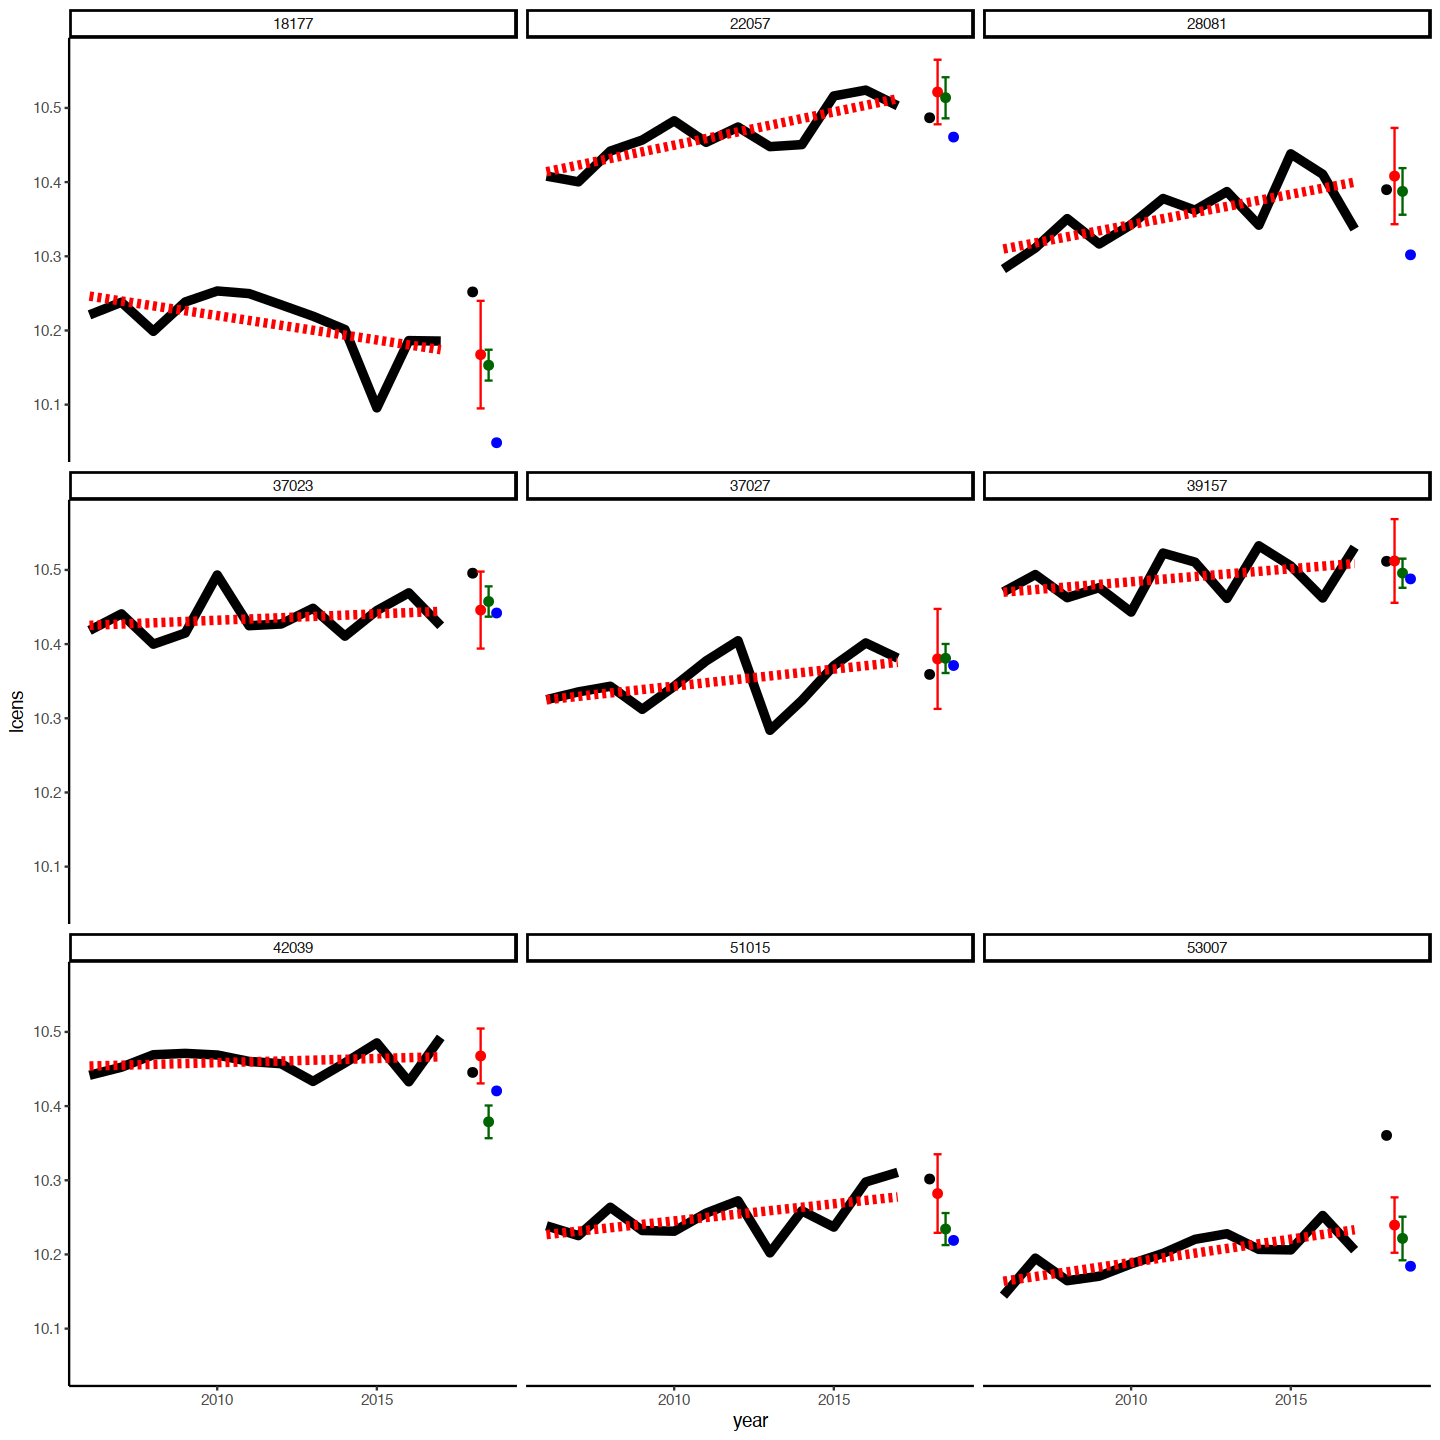

In [93]:
options(repr.plot.width=12, repr.plot.height=12)

# split the data by population decile
res <- res %>%
    mutate(acs_quartile = quantcut(lcens, q = 4, na.rm = TRUE))
levels(res$acs_quartile) <- c(1:4)

countyids <- res %>% 
    filter(acs_quartile == 1) %>%
    sample_n(9) %>%
    .$countyid

res_samp <- res %>%
    filter(countyid %in% countyids)
tr_samp <- train %>%
    filter(countyid %in% countyids)

ggplot() +
    geom_line(
        data = tr_samp,
        aes(x = year, y = lcens),
        size = 2
    ) +
    geom_smooth(
        data = tr_samp,
        aes(x = year, y = lcens),
        method = "lm",
        fill = NA, 
        color = 'red',
        linetype = 'dashed',
        size = 2
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = lcens),
        size = 2
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = .mean),
        color = 'red',
        size = 2,
        position = position_nudge(x = .25)
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = lprd_4),
        color = 'darkgreen',
        size = 2,
        position = position_nudge(x = .5)
    ) +
    geom_point(
        data = res_samp,
        aes(x = year, y = lig),
        color = 'blue',
        size = 2,
        position = position_nudge(x = .75)
    ) +
    geom_errorbar(
        data = res_samp,
        aes(x = year, ymin = `90%_upper`, ymax = `90%_lower`),
        color = 'red',
        width = 0.25,
        position = position_nudge(x = .25)
    ) + 
    geom_errorbar(
        data = res_samp,
        aes(x = year, ymin = ll90_4, ymax = lu90_4),
        color = 'darkgreen',
        width = 0.25,
        position = position_nudge(x = .5)
    ) +
    facet_wrap(. ~ countyid) +
    theme_classic()